In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, expon, t, f, beta, pareto, chi2, rayleigh, gamma
from statsmodels.tsa.stattools import acf
from scipy.stats import median_test
from scipy.stats import ttest_ind
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import curve_fit
import itertools
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import arch
import pmdarima as pm
from pmdarima.arima import auto_arima
import pandas_datareader as pdr
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

### I. Импорт данных

Импортируем данные, полученных в результате предобработки датасетов

In [2]:
df = pd.read_excel('df_import.xlsx', index_col ='Год')
df28_40 = pd.read_excel('df28_40_import.xlsx', index_col ='Год')
df50_67 = pd.read_excel('df50_67_import.xlsx', index_col ='Год')
df72_83 = pd.read_excel('df72_83_import.xlsx', index_col ='Год')

In [3]:
df.head(5)

,"Импорт России важнейших товаров, млн долл США","Оборот средних организаций по субъектам РФ, млрд. руб.","Индекс промышленного производства, в%",Средняя доля импорта отдельных товаров в их товарных ресурсах
Год,,,,
2011,14267.700000,3925.6,105.0,23.414286
2012,15562.984615,4136.1,109.0,24.328571
2013,15495.900000,4295.9,109.0,24.221429
2014,13751.823077,4515.8,112.0,19.492857
2015,8352.330769,4715.0,112.0,16.092857


In [5]:
df28_40 = pd.read_excel('df28_40_import.xlsx', index_col ='Год')
df50_67 = pd.read_excel('df50_67_import.xlsx', index_col ='Год')
df72_83 = pd.read_excel('df72_83_import.xlsx', index_col ='Год')

df = pd.read_excel('df_import.xlsx')
y = df['Импорт России важнейших товаров, млн долл США']
X = df.drop(['Импорт России важнейших товаров, млн долл США'], axis = 1)

df28_40 = pd.read_excel('df28_40_import.xlsx')
y28_40 = df28_40['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США']
X28_40 = df28_40.drop(['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США'], axis = 1)

df50_67 = pd.read_excel('df50_67_import.xlsx')
y50_67 = df50_67['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США']
X50_67 = df50_67.drop(['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США'], axis = 1)

df72_83 = pd.read_excel('df72_83_import.xlsx')
y72_8 = df72_83['72-83 Импорт металлов и изделий из них, млн. долл. США']
X72_83 = df72_83.drop(['72-83 Импорт металлов и изделий из них, млн. долл. США'], axis = 1)

In [6]:
df28_40.head()

,Год,"28-40 Импорт продукции химической промышленности, каучука, млн. долл. США","Оборот средних организаций по субъектам РФ, млрд. руб.","Индекс промышленного производства, в%",Средняя доля импорта отдельных товаров в их товарных ресурсах
0,2011,42057.8,3925.6,105.0,23.414286
1,2012,43896.3,4136.1,109.0,24.328571
2,2013,45923.8,4295.9,109.0,24.221429
3,2014,42629.7,4515.8,112.0,19.492857
4,2015,30847.3,4715.0,112.0,16.092857


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Год                                                            11 non-null     int64  
 1   Импорт России важнейших товаров, млн долл США                  11 non-null     float64
 2   Оборот средних организаций по субъектам РФ, млрд. руб.         11 non-null     float64
 3   Индекс промышленного производства, в%                          11 non-null     float64
 4   Средняя доля импорта отдельных товаров в их товарных ресурсах  11 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 572.0 bytes


# II. Временные ряды

### 1. Предварительный анализ временных рядов. 

#### Датасет: импорт важнейших товаров

In [8]:
# расчет статистических показателей
def statistic_values(column):
    print(f'Для столбца {column.name}:')
    matrix = pd.DataFrame()
    print('Среднее значение:', column.mean())
    print('Медиана:', column.median())
    print('Стандартное отклонение:', column.std())
    print('Минимальное значение:', column.min())
    print('Максимальное значение:', column.max())

    # расчет корреляций
    corr = column.corr(column.shift())
    print('Коэффициент корреляции:', corr)
    print()

  
    
for i in X.columns:    
    statistic_values(X[f'{i}'])

Для столбца Год:
Среднее значение: 2016.0
Медиана: 2016.0
Стандартное отклонение: 3.3166247903554
Минимальное значение: 2011
Максимальное значение: 2021
Коэффициент корреляции: 0.9999999999999999

Для столбца Оборот средних организаций по субъектам РФ, млрд. руб.:
Среднее значение: 5859.090909090909
Медиана: 6141.6
Стандартное отклонение: 1733.4146563673362
Минимальное значение: 3925.6
Максимальное значение: 9495.9
Коэффициент корреляции: 0.8442004579566553

Для столбца Индекс промышленного производства, в%:
Среднее значение: 116.63636363636364
Медиана: 114.0
Стандартное отклонение: 8.380963277245964
Минимальное значение: 105.0
Максимальное значение: 131.7
Коэффициент корреляции: 0.9320287535210309

Для столбца Средняя доля импорта отдельных товаров в их товарных ресурсах:
Среднее значение: 17.04025974025974
Медиана: 15.6285714285714
Стандартное отклонение: 4.971763404905732
Минимальное значение: 11.8071428571429
Максимальное значение: 24.3285714285714
Коэффициент корреляции: 0.9318638

#### Датасет Импорт продукции химической промышленности, каучука

In [10]:
# расчет статистических показателей
    
for i in X28_40.columns:    
    statistic_values(X28_40[f'{i}'])

Для столбца Год:
Среднее значение: 2016.0
Медиана: 2016.0
Стандартное отклонение: 3.3166247903554
Минимальное значение: 2011
Максимальное значение: 2021
Коэффициент корреляции: 0.9999999999999999

Для столбца Оборот средних организаций по субъектам РФ, млрд. руб.:
Среднее значение: 5859.090909090909
Медиана: 6141.6
Стандартное отклонение: 1733.4146563673362
Минимальное значение: 3925.6
Максимальное значение: 9495.9
Коэффициент корреляции: 0.8442004579566553

Для столбца Индекс промышленного производства, в%:
Среднее значение: 116.63636363636364
Медиана: 114.0
Стандартное отклонение: 8.380963277245964
Минимальное значение: 105.0
Максимальное значение: 131.7
Коэффициент корреляции: 0.9320287535210309

Для столбца Средняя доля импорта отдельных товаров в их товарных ресурсах:
Среднее значение: 17.04025974025974
Медиана: 15.6285714285714
Стандартное отклонение: 4.971763404905732
Минимальное значение: 11.8071428571429
Максимальное значение: 24.3285714285714
Коэффициент корреляции: 0.9318638

#### Датасет: Импорт металлов и изделий из них

In [13]:
# расчет статистических показателей
def statistic_values(column):
    print(f'Для столбца {column.name}:')
    matrix = pd.DataFrame()
    #matrix['Среднее значение'] = column.mean()
    #matrix['Медиана'] = column.median()
    #matrix['Стандартное отклонение'] = column.std()
    #matrix['Минимальное значение'] = column.min()
    #matrix['Максимальное значение'] = column.max()
    print('Среднее значение:', column.mean())
    print('Медиана:', column.median())
    print('Стандартное отклонение:', column.std())
    print('Минимальное значение:', column.min())
    print('Максимальное значение:', column.max())

    # расчет корреляций
    corr = column.corr(column.shift())
    print('Коэффициент корреляции:', corr)
    print()

  
    
for i in X.columns:    
    statistic_values(X[f'{i}'])

Для столбца Год:
Среднее значение: 2016.0
Медиана: 2016.0
Стандартное отклонение: 3.3166247903554
Минимальное значение: 2011
Максимальное значение: 2021
Коэффициент корреляции: 0.9999999999999999

Для столбца Оборот средних организаций по субъектам РФ, млрд. руб.:
Среднее значение: 5859.090909090909
Медиана: 6141.6
Стандартное отклонение: 1733.4146563673362
Минимальное значение: 3925.6
Максимальное значение: 9495.9
Коэффициент корреляции: 0.8442004579566553

Для столбца Индекс промышленного производства, в%:
Среднее значение: 116.63636363636364
Медиана: 114.0
Стандартное отклонение: 8.380963277245964
Минимальное значение: 105.0
Максимальное значение: 131.7
Коэффициент корреляции: 0.9320287535210309

Для столбца Средняя доля импорта отдельных товаров в их товарных ресурсах:
Среднее значение: 17.04025974025974
Медиана: 15.6285714285714
Стандартное отклонение: 4.971763404905732
Минимальное значение: 11.8071428571429
Максимальное значение: 24.3285714285714
Коэффициент корреляции: 0.9318638

**Анализ:** 

- График временного ряда показывает, что значения прироста производства по основным импортозамещающим продуктам животноводства имеют тенденцию к увеличению в начале периода до 2013 года, затем, с 2014 года тенденция идет в низ и продолжается по сей день. 
- Оборот средних организаций имеет твердую динамику роста на всем интревале. 
- Удельный вес потребительских товаров в общем обхеме иморта имеет резкий тред снижения (с небольшим ростом в 2017 году)

* Стандартное отклонение равно 0.0158, 1733.41, 1.61, что говорит о том, что значения не имеют большого расброса

### Проверка на автокорреляцию

#### Датасет: Импорт России важнейших товаров

#### Тест Льюнга-Бокса

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox
X = np.column_stack((np.ones(len(df)), range(len(df))))
y = df['Импорт России важнейших товаров, млн долл США'].values
model = OLS(y, X).fit()
# p-value (<0.05) предполагает наличие автокорреляции квадратов остатков
acorr_ljungbox(model.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,14.19861,0.164124


**Анализ:** 

p-value (>0.05) = 0.164 => автокорреляция есть

#### Датасет: Импорт продукции химической промышленности, каучука

In [15]:
X28_40 = np.column_stack((np.ones(len(df28_40)), range(len(df28_40))))
y = df28_40['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США'].values
model28_40 = OLS(y, X28_40).fit()
acorr_ljungbox(model28_40.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,10.780225,0.374895


**Анализ:** 

p-value (>0.05) = 0.375 => автокорреляция есть

#### Датасет: Импорт текстиля, текстильных изделий и обуви

In [16]:
X50_67 = np.column_stack((np.ones(len(df50_67)), range(len(df50_67))))
y = df50_67['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США'].values
model50_67 = OLS(y, X28_40).fit()
acorr_ljungbox(model50_67.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,9.577707,0.47829


**Анализ:** 

p-value (>0.05) = 0.478 => автокорреляция есть

#### Датасет: Импорт металлов и изделий из них

In [17]:
X72_83 = np.column_stack((np.ones(len(df72_83)), range(len(df72_83))))
y = df72_83['72-83 Импорт металлов и изделий из них, млн. долл. США'].values
model72_83 = OLS(y, X72_83).fit()
acorr_ljungbox(model72_83.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,9.243349,0.509175


**Анализ:** 

p-value (>0.05) = 0.51 => автокорреляция отсутствует

In [18]:
df = pd.read_excel('df_import.xlsx', index_col ='Год')
df28_40 = pd.read_excel('df28_40_import.xlsx', index_col ='Год')
df50_67 = pd.read_excel('df50_67_import.xlsx', index_col ='Год')
df72_83 = pd.read_excel('df72_83_import.xlsx', index_col ='Год')

y = df['Импорт России важнейших товаров, млн долл США']
X = df.drop(['Импорт России важнейших товаров, млн долл США'], axis = 1)

y28_40 = df28_40['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США']
X28_40 = df28_40.drop(['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США'], axis = 1)

y50_67 = df50_67['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США']
X50_67 = df50_67.drop(['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США'], axis = 1)

y72_83 = df72_83['72-83 Импорт металлов и изделий из них, млн. долл. США']
X72_83 = df72_83.drop(['72-83 Импорт металлов и изделий из них, млн. долл. США'], axis = 1)

### Выявление аномальных наблюдений с помощью использования распределения Стьюдента, Метода Ирвина			

**Шаг №1.** Проверим ряд на нормальность с помощью теста Шапиро-Уилка, чтобы выбрать метод для выявления аномальных наблюдений.

In [24]:
import math
import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm

In [25]:
def Shapiro(column):
    np.random.seed (1)

    #тест Шапиро-Уилка
    print(f'статистика для {column.name}:')
    print(f'{shapiro(column.values)}')
    print()
    
for i in X.columns:
    Shapiro(X[f'{i}'])
    

статистика для Оборот средних организаций по субъектам РФ, млрд. руб.:
ShapiroResult(statistic=0.9081743955612183, pvalue=0.23201127350330353)

статистика для Индекс промышленного производства, в%:
ShapiroResult(statistic=0.9507124423980713, pvalue=0.6530702114105225)

статистика для Средняя доля импорта отдельных товаров в их товарных ресурсах:
ShapiroResult(statistic=0.8516103029251099, pvalue=0.044791921973228455)

статистика для intercept:
ShapiroResult(statistic=1.0, pvalue=1.0)



C:\Users\valentina.filippenko\AppData\Local\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [26]:
for i in X28_40.columns:
    Shapiro(X28_40[f'{i}'])

статистика для Оборот средних организаций по субъектам РФ, млрд. руб.:
ShapiroResult(statistic=0.9081743955612183, pvalue=0.23201127350330353)

статистика для Индекс промышленного производства, в%:
ShapiroResult(statistic=0.9507124423980713, pvalue=0.6530702114105225)

статистика для Средняя доля импорта отдельных товаров в их товарных ресурсах:
ShapiroResult(statistic=0.8516103029251099, pvalue=0.044791921973228455)



In [27]:
for i in X50_67.columns:
    Shapiro(X50_67[f'{i}'])

статистика для Оборот средних организаций по субъектам РФ, млрд. руб.:
ShapiroResult(statistic=0.9081743955612183, pvalue=0.23201127350330353)

статистика для Индекс промышленного производства, в%:
ShapiroResult(statistic=0.9507124423980713, pvalue=0.6530702114105225)

статистика для Средняя доля импорта отдельных товаров в их товарных ресурсах:
ShapiroResult(statistic=0.8516103029251099, pvalue=0.044791921973228455)



In [28]:
for i in X72_83.columns:
    Shapiro(X72_83[f'{i}'])

статистика для Оборот средних организаций по субъектам РФ, млрд. руб.:
ShapiroResult(statistic=0.9081743955612183, pvalue=0.23201127350330353)

статистика для Индекс промышленного производства, в%:
ShapiroResult(statistic=0.9507124423980713, pvalue=0.6530702114105225)

статистика для Средняя доля импорта отдельных товаров в их товарных ресурсах:
ShapiroResult(statistic=0.8516103029251099, pvalue=0.044791921973228455)



#### Выводы: 

- Если pvalue > 0.05, значит, данные распределены нормально. 

- Если < 0.05, следовательно, не распределены нормально. 

1. Для признака 1: pvalue (> 0,05) = 0.85 => данные распределены нормально

2. Для признака 2: pvalue (> 0,05) = 0.23 => данные распределены нормально

3. Для признака 3: pvalue (> 0,05) = 0.337 => данные распределены нормально

### 3.1  **Ирвин**

Для выявления аномальных наблюдений в нашем случае можно использовать метод Ирвина. Он основан на вычислении значения Z-критерия для каждого значения в выборке. Затем значения, для которых Z-критерий превышает пороговое значение, считаются аномальными.

In [29]:
df = pd.read_excel('df_import.xlsx', index_col ='Год')
df28_40 = pd.read_excel('df28_40_import.xlsx', index_col ='Год')
df50_67 = pd.read_excel('df50_67_import.xlsx', index_col ='Год')
df72_83 = pd.read_excel('df72_83_import.xlsx', index_col ='Год')

y = df['Импорт России важнейших товаров, млн долл США']
X = df.drop(['Импорт России важнейших товаров, млн долл США'], axis = 1)

y28_40 = df28_40['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США']
X28_40 = df28_40.drop(['28-40 Импорт продукции химической промышленности, каучука, млн. долл. США'], axis = 1)

y50_67 = df50_67['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США']
X50_67 = df50_67.drop(['50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США'], axis = 1)

y72_83 = df72_83['72-83 Импорт металлов и изделий из них, млн. долл. США']
X72_83 = df72_83.drop(['72-83 Импорт металлов и изделий из них, млн. долл. США'], axis = 1)

Критические значения:

In [30]:
def Irvin(df, column):
    Sy = df[column].std()
    dif = (df[column][1:].reset_index(drop=True) - df[column][:-1].reset_index(drop=True))
    l_n = list(dif / Sy)
    df['lambda_набл'] = [np.nan] + l_n
    df['lambda_крит'] = [np.nan] + [1.46] * (df.shape[0] - 1)  # из таблицы по n
    df['irvin'] = df['lambda_набл'] > df['lambda_крит']
    print(f'lambda_набл: {df["lambda_набл"]}')
    print(f'lambda_крит: {df["lambda_крит"]}')

    print(df['irvin'].sum()) # по Ирвину на ур знач 5% нет аномал знач

    
for i in X.columns:
    print(f'i:{i}')
    Irvin(df, i)

i:Оборот средних организаций по субъектам РФ, млрд. руб.
lambda_набл: Год
2011         NaN
2012    0.121437
2013    0.092188
2014    0.126859
2015    0.114918
2016    1.180560
2017   -0.279564
2018    0.199145
2019   -0.277141
2020    0.820519
2021    1.114563
Name: lambda_набл, dtype: float64
lambda_крит: Год
2011     NaN
2012    1.46
2013    1.46
2014    1.46
2015    1.46
2016    1.46
2017    1.46
2018    1.46
2019    1.46
2020    1.46
2021    1.46
Name: lambda_крит, dtype: float64
0
i:Индекс промышленного производства, в%
lambda_набл: Год
2011         NaN
2012    0.477272
2013    0.000000
2014    0.357954
2015    0.000000
2016    0.238636
2017    0.501136
2018    0.489204
2019    0.441477
2020   -0.262500
2021    0.942612
Name: lambda_набл, dtype: float64
lambda_крит: Год
2011     NaN
2012    1.46
2013    1.46
2014    1.46
2015    1.46
2016    1.46
2017    1.46
2018    1.46
2019    1.46
2020    1.46
2021    1.46
Name: lambda_крит, dtype: float64
0
i:Средняя доля импорта отдельных то

In [31]:
def Irvin(df, column):
    Sy = df[column].std()
    dif = (df[column][1:].reset_index(drop=True) - df[column][:-1].reset_index(drop=True))
    l_n = list(dif / Sy)
    df['lambda_набл'] = [np.nan] + l_n
    df['lambda_крит'] = [np.nan] + [1.46] * (df.shape[0] - 1)  # из таблицы по n
    df['irvin'] = df['lambda_набл'] > df['lambda_крит']
    print(df['irvin'].sum()) # по Ирвину на ур знач 5% нет аномал значений
    
for i in X28_40.columns:
    Irvin(df28_40, i)

0
0
0


In [32]:
for i in X50_67.columns:
    Irvin(df50_67, i)

0
0
0


In [33]:
for i in X72_83.columns:
    Irvin(df72_83, i)

0
0
0


####  **Вывод**: 

Для каждого значения считаем lambda_наблюдаемое (в числителе - разность между текущим значением и предыдущим, в знаменателе - стандартное отклонение). Затем находим lambda_критическое по таблице и сравниваем. 
Если lambda_наблюдаемое > lambda_критическое, то данное наблюдение можно считать аномальным при 5% уровне значимости.

- по методу Ирвина аномалий в данных нет на 5% уровне значимости

### 4. Тест Дики-Фуллера на проверку стационарности данных

In [34]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, expon, t, f, beta, pareto, chi2, rayleigh, gamma

In [110]:
def fuller(series):
    #series = df[column]
    print('Статистика Дики-Фуллера: %f' % adfuller(series)[0]) 
    print('Р-value: %f' % adfuller(series)[1]) 
    if adfuller(series)[1]>0.05:
        print('Ряд не является стационарным')
        return False
    else:
        print('Ряд является стационарным') 
        return True

In [23]:
X.columns

Index(['Оборот средних организаций по субъектам РФ, млрд. руб.',
       'Индекс промышленного производства, в%',
       'Средняя доля импорта отдельных товаров в их товарных ресурсах'],
      dtype='object')

In [111]:
for i in X.columns:
    fuller(df[f'{i}'])

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


Теперь нам нужно преобразовать временной ряд с помощью функции to_stationary() столько раз, чтобы временной ряд стал стационарным:


In [123]:
def to_stationary(ts):   
    ts_diff = pd.Series(ts)
    d = 0
    while fuller(ts_diff) is False:
        ts_diff = ts_diff.diff().dropna()
        d = d + 1
    return ts_diff

In [124]:
new_df = pd.DataFrame()
for i in X.columns:
    ts = df[f'{i}']
    new_df[f'{i}'] = to_stationary(ts)  

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: -107.543431
Р-value: 0.000000
Ряд является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.423451
Р-value: 0.000270
Ряд является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [122]:
new_df.head(3)

,"Оборот средних организаций по субъектам РФ, млрд. руб.","Индекс промышленного производства, в%",Средняя доля импорта отдельных товаров в их товарных ресурсах
Год,,,
2012,210.5,4.0,24.328571
2013,159.8,0.0,24.221429
2014,219.9,3.0,19.492857


In [37]:
for i in X28_40.columns:
    fuller(df28_40, i)

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [125]:
new_df28_40 = pd.DataFrame()
for i in X28_40.columns:
    ts = df28_40[f'{i}']
    new_df28_40[f'{i}'] = to_stationary(ts)  

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: -107.543431
Р-value: 0.000000
Ряд является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.423451
Р-value: 0.000270
Ряд является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [129]:
for i in X50_67.columns:
    fuller(df50_67[f'{i}'])

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [130]:
new_df50_67 = pd.DataFrame()
for i in X50_67.columns:
    ts = df50_67[f'{i}']
    new_df50_67[f'{i}'] = to_stationary(ts) 

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: -107.543431
Р-value: 0.000000
Ряд является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.423451
Р-value: 0.000270
Ряд является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [133]:
for i in X72_83.columns:
    fuller(df72_83[f'{i}'])

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


In [134]:
new_df72_83 = pd.DataFrame()
for i in X72_83.columns:
    ts = df72_83[f'{i}']
    new_df72_83[f'{i}'] = to_stationary(ts) 

Статистика Дики-Фуллера: 0.375527
Р-value: 0.980556
Ряд не является стационарным
Статистика Дики-Фуллера: -107.543431
Р-value: 0.000000
Ряд является стационарным
Статистика Дики-Фуллера: 1.347399
Р-value: 0.996862
Ряд не является стационарным
Статистика Дики-Фуллера: -4.423451
Р-value: 0.000270
Ряд является стационарным
Статистика Дики-Фуллера: -4.611659
Р-value: 0.000123
Ряд является стационарным


### Итог - приведение к стационарности 

In [135]:
for i in X.columns:
    fuller(new_df[f'{i}'])

Статистика Дики-Фуллера: -107.543431
Р-value: 0.000000
Ряд является стационарным
Статистика Дики-Фуллера: -4.423451
Р-value: 0.000270
Ряд является стационарным
Статистика Дики-Фуллера: -6.724240
Р-value: 0.000000
Ряд является стационарным


### Вывод

Возьмем уровень значимости = 0.05

Если P-value > 0.05, то гипотеза Н0 о стационарности ряда принимается и ряд не стационарен 

Если P-value < 0.05, то гипотеза Н0 о стационарности ряда отвергается и ряд стационарен 

Следовательно, в нашем случае делаем вывод, что наш ряд нестационарен

### 5. Проверка наличия тренда с помощью: Критерия серий, основанный на медиане, Метода проверки разности средних уровней, Метода Фостера-Стьюарта

**Фостер-Стьюарт**

In [44]:
def Forrest_Stuart(df, column):
    # Вычисление первых разностей
    df['Diff_Y'] = df[column].diff()
    # Вычисление автокорреляции первых разностей
    acf_diff = acf(df['Diff_Y'].dropna())
    # Вычисление статистики теста Фостера-Стьюарта
    test_statistic = np.sum(acf_diff[1:] ** 2) * len(df)

    # Критическое значение для уровня значимости 0.05
    critical_value = 1.036
    critical_value = t.ppf(0.95 , len(df)-1) 

    # Проверка наличия тренда
    if test_statistic > critical_value:
        print("Есть тренд")
    else:
        print("Тренд отсутствует")
    print(f'статистика равна: {test_statistic}')
    print(f'критическое значение равно: {critical_value}')

In [137]:
for i in X.columns:
    Forrest_Stuart(df, i)

Есть тренд
статистика равна: 3.221061300351435
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 4.319862711743881
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 2.559838762359781
критическое значение равно: 1.8124611228107335


In [138]:
for i in X.columns:
    Forrest_Stuart(new_df, i)

Есть тренд
статистика равна: 6.580493024736567
критическое значение равно: 1.8331129326536335
Есть тренд
статистика равна: 4.649729892691427
критическое значение равно: 1.8331129326536335
Тренд отсутствует
статистика равна: 1.5478975353223368
критическое значение равно: 1.8331129326536335


In [46]:
for i in X28_40.columns:
    Forrest_Stuart(df28_40, i)

Есть тренд
статистика равна: 3.221061300351435
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 4.319862711743881
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 2.559838762359781
критическое значение равно: 1.8124611228107335


In [47]:
for i in X50_67.columns:
    Forrest_Stuart(df50_67, i)

Есть тренд
статистика равна: 3.221061300351435
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 4.319862711743881
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 2.559838762359781
критическое значение равно: 1.8124611228107335


In [48]:
for i in X72_83.columns:
    Forrest_Stuart(df72_83, i)

Есть тренд
статистика равна: 3.221061300351435
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 4.319862711743881
критическое значение равно: 1.8124611228107335
Есть тренд
статистика равна: 2.559838762359781
критическое значение равно: 1.8124611228107335


**Вывод:**

Для проведения теста Фостера-Стьюарта, для начала, необохимо рассчитать разности значение (для каждого наблюдения из текущего вычитается предыдущее). Затем вычисляются автокорреляции разностей, статистика теста Фостера-Стьюарта, которая получилась равной (test_statistic).
Находится критическое значение для уровня значимости 0.05, оно равно critical_value.

И производится проверка. Если test_statistic > critical_value, то тренд присутствует, если нет, то отсутсвтует. 

- Для всех данныз мы наблидаем наличие тренда

***

### Построение  эконометрических моделей 

### 6.1 ARIMAX 

In [9]:
import statsmodels.api as sm

### 1. Датсет: Импорт России важнейших товаров

#### ARIMAX. Подбор параметров

Для подбора оптимальных параметров модели SARIMAX можно использовать перебор различных комбинаций параметров и оценку их производительности. Библиотека statsmodels предоставляет удобные средства для этого, но нам также потребуется написать некоторые дополнительные функции для автоматизации процесса. В данном примере, мы сосредоточимся на подборе параметров p, d, q для основной части модели и P, D, Q и s для сезонной части.

Выберем лучшую модель с помощью информационного критерия Акаике


In [9]:
import warnings
warnings.filterwarnings("ignore")  # Игнорируем предупреждения для упрощения вывода
# Определение диапазонов для параметров
p = d = q = range(0, 3)  # Основные параметры
pdq = list(itertools.product(p, d, q))  # Все комбинации p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]  # Сезонные параметры
# Для хранения лучшей модели 
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_results = None
# Подбор параметров
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df['Импорт России важнейших товаров, млн долл США'],
                          exog=df[['Оборот средних организаций по субъектам РФ, млрд. руб.', 
                                   'Индекс промышленного производства, в%']],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            # Сравниваем с лучшим AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_results = results
           
            print(f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}')
        except:
            continue

print(f'Лучший AIC: {best_aic}')
print(f'Лучшие параметры ARIMA: {best_pdq}')
print(f'Лучшие сезонные параметры: {best_seasonal_pdq}')


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:195.16259338777732
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:8.0
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:10.0
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:6.0
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:8.0
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:10.0
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:6.0
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:8.0
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:10.0
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:8.0
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:10.0
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:12.0
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:8.0
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:10.0
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:12.0
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:8.0
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:10.0
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:12.0
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:10.0
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:12.0
ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:14.0
ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:10.0
ARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:12.0
ARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:14.0
ARIMA(0, 0, 0)x(2, 2, 0, 12) - AIC

#### Результат
- Лучший AIC: 6.0
- Лучшие параметры ARIMA: (0, 0, 0)
- Лучшие сезонные параметры: (0, 1, 0, 12)

### Прогнозирование ARIMAX

In [11]:
# Создание и обучение модели ARIMAX
X_with_const = sm.add_constant(X)
arimax_model = SARIMAX(y, exog=X_with_const, order=(0,0,0), seasonal_order=(0,0,0,0))
results = arimax_model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)



                                             SARIMAX Results                                             
Dep. Variable:     Импорт России важнейших товаров, млн долл США   No. Observations:                   11
Model:                                                   SARIMAX   Log Likelihood                 -97.619
Date:                                           Sat, 27 Apr 2024   AIC                            205.237
Time:                                                   00:38:12   BIC                            207.227
Sample:                                                        0   HQIC                           203.983
                                                            - 11                                         
Covariance Type:                                             opg                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [14]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# Вычисление метрик MSE и MAE
mse = mean_squared_error(y[-4:], forecast.predicted_mean)
mae = mean_absolute_error(y[-4:], forecast.predicted_mean)

print("MSE:", mse)
print("MAE:", mae)

MSE: 6854236.017832555
MAE: 2184.7979288630486


### Проверка на автокорреляцию

In [91]:
acorr_ljungbox(results.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.671322,0.988137


Вывод: 0.988137>0.05 => нулевая гипотеза принимается, и делается вывод об отсутствии автокорреляции во временном ряду

### 2. Датсет: 28-40 Импорт продукции химической промышленности, каучука

#### Прогногзирование ARIMAX

In [11]:
# Создание и обучение модели ARIMAX
X_with_const = sm.add_constant(X28_40)
arimax_model = SARIMAX(y28_40, exog=X_with_const, order=(0,0,0), seasonal_order=(0,0,0,0))
results = arimax_model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                                           SARIMAX Results                                                           
Dep. Variable:     28-40 Импорт продукции химической промышленности, каучука, млн. долл. США   No. Observations:                   11
Model:                                                                               SARIMAX   Log Likelihood                 -98.031
Date:                                                                       Fri, 03 May 2024   AIC                            206.061
Time:                                                                               09:17:59   BIC                            208.051
Sample:                                                                                    0   HQIC                           204.807
                                                                                        - 11                                         
Covariance Type:                                              

In [15]:
# Вычисление метрик MSE и MAE
mse28_40 = mean_squared_error(y28_40[-4:], forecast.predicted_mean)
mae28_40 = mean_absolute_error(y28_40[-4:], forecast.predicted_mean)

print("MSE:", mse28_40)
print("MAE:", mae28_40)

MSE: 1208495.3428738862
MAE: 978.5175775520511


**Прогноз**
- 2022:    42025.604762
- 2023:    45066.554978
- 2024:    40909.956258
- 2025:    41291.801762

In [93]:
acorr_ljungbox(results.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.113114,0.277558


### 3. Датсет: 50-67 Импорт текстиля, текстильных изделий и обуви

**Результат** 

- Лучший AIC: 6.0
- Лучшие параметры ARIMA: (0, 0, 0)
- Лучшие сезонные параметры: (0, 1, 0, 12)

#### Прогнозирование ARIMAX

In [16]:
# Создание и обучение модели ARIMAX
X_with_const = sm.add_constant(X50_67)
arimax_model = SARIMAX(y50_67, exog=X_with_const, order=(0,0,0), seasonal_order=(0,0,0,0))
results = arimax_model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                                       SARIMAX Results                                                        
Dep. Variable:     50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США   No. Observations:                   11
Model:                                                                        SARIMAX   Log Likelihood                 -90.545
Date:                                                                Fri, 03 May 2024   AIC                            191.091
Time:                                                                        09:20:35   BIC                            193.080
Sample:                                                                             0   HQIC                           189.836
                                                                                 - 11                                         
Covariance Type:                                                                  opg                          

In [17]:
# Вычисление метрик MSE и MAE
mse50_67 = mean_squared_error(y50_67[-4:], forecast.predicted_mean)
mae50_67 = mean_absolute_error(y50_67[-4:], forecast.predicted_mean)

print("MSE:", mse50_67)
print("MAE:", mae50_67)

MSE: 685752.7139117955
MAE: 728.1781685721776


**Прогноз**
- 2022:    13200.893757
- 2023:    14089.126322
- 2024:    12608.002967
- 2025:    12024.716631

In [95]:
acorr_ljungbox(results.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,15.124262,0.127597


### 4. Датсет: 72-83 Импорт металлов и изделий из них

**Результат** 

- Лучший AIC: 6.0
- Лучшие параметры ARIMA: (0, 0, 0)
- Лучшие сезонные параметры: (0, 1, 0, 12)

#### Прогнозирование ARIMAX

In [18]:
# Создание и обучение модели ARIMAX
X_with_const = sm.add_constant(X72_83)
arimax_model = SARIMAX(y72_83, exog=X_with_const, order=(0,0,0), seasonal_order=(0,0,0,0))
results = arimax_model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)

                                                 SARIMAX Results                                                  
Dep. Variable:     72-83 Импорт металлов и изделий из них, млн. долл. США   No. Observations:                   11
Model:                                                            SARIMAX   Log Likelihood                 -91.777
Date:                                                    Fri, 03 May 2024   AIC                            193.553
Time:                                                            09:21:21   BIC                            195.543
Sample:                                                                 0   HQIC                           192.299
                                                                     - 11                                         
Covariance Type:                                                      opg                                         
                                                                    coef    std 

In [19]:
# Вычисление метрик MSE и MAE
mse72_83 = mean_squared_error(y72_83[-4:], forecast.predicted_mean)
mae72_83 = mean_absolute_error(y72_83[-4:], forecast.predicted_mean)

print("MSE:", mse72_83)
print("MAE:", mae72_83)

MSE: 579257.9102488046
MAE: 698.9236833511432


In [97]:
acorr_ljungbox(results.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.549739,0.249947


### 6.2 SARIMAX

### Датасет: Импорт России важнейших товаров

In [20]:
# Добавляем константу к независимым переменным для учета свободного члена (intercept) в модели
X_with_const = sm.add_constant(X)
model = SARIMAX(y, exog=X_with_const, order=(0,0,0), seasonal_order=(0,1,0,12))
results = model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                             SARIMAX Results                                             
Dep. Variable:     Импорт России важнейших товаров, млн долл США   No. Observations:                   11
Model:                                      SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                                           Fri, 03 May 2024   AIC                             10.000
Time:                                                   09:22:00   BIC                                nan
Sample:                                                        0   HQIC                               nan
                                                            - 11                                         
Covariance Type:                                             opg                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [21]:
# Вычисление метрик MSE и MAE
mse = mean_squared_error(y[-4:], forecast.predicted_mean)
mae = mean_absolute_error(y[-4:], forecast.predicted_mean)

print("MSE:", mse)
print("MAE:", mae)

MSE: 64048778.57673072
MAE: 6674.140384615383


### Тест на автокорреляцию

In [100]:
acorr_ljungbox(results.resid**2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,8.613027,0.569179


In [99]:
# Вывод статистики логарифмического правдоподобия
print(f'Log-Likelihood: {results.llf}')

Log-Likelihood: 0.0


#### Проверка адекватности модели. Статистика Харке-Бера

Значение статистики Jarque-Bera: 0.8750648307414919, p-value: 0.6456275978307423


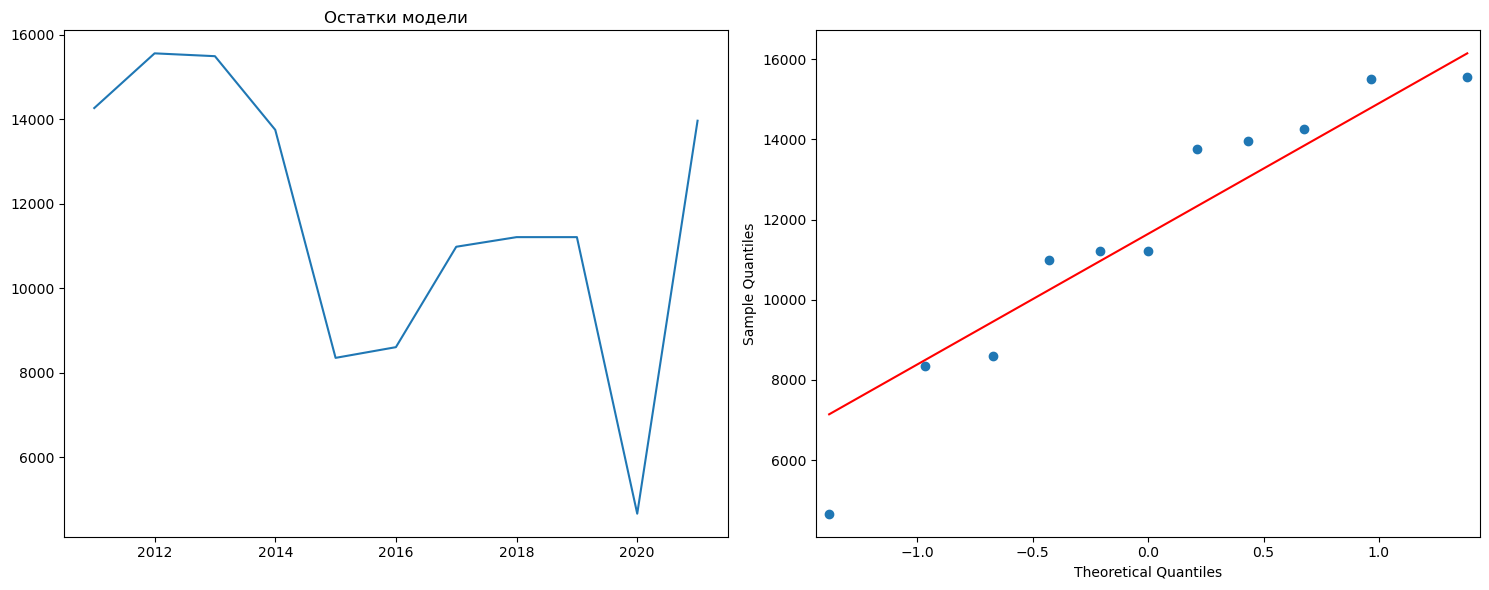

In [101]:
# Визуализация остатков
residuals = results.resid
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].plot(residuals)
ax[0].set_title('Остатки модели')
sm.qqplot(residuals, line='s', ax=ax[1])  # Q-Q график для остатков
plt.tight_layout()

# Проверка на нормальность остатков
from scipy import stats
jb_test = stats.jarque_bera(residuals)
print(f"Значение статистики Jarque-Bera: {jb_test[0]}, p-value: {jb_test[1]}")


Если значение p-value (второе значение в выводе Jarque-Bera теста) меньше выбранного уровня значимости (обычно 0.05), то гипотеза о нормальности распределения остатков отклоняется. Необходимо убедиться, что остатки имеют нормальное распределение, для того чтобы модель считалась адекватной.

### Проверка адекватности модели. Статистика Дарбина-Уотсона

In [102]:
from statsmodels.stats.stattools import durbin_watson

# Вычисляем статистику Дарбина-Уотсона для остатков
dw_statistic = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_statistic}")


Статистика Дарбина-Уотсона: 0.10520372502416642


Значение статистики Дарбина-Уотсона близко к 2 указывает на отсутствие (нулевую) автокорреляцию остатков. Значения меньше 2 могут указывать на положительную автокорреляцию, значения больше 2 - на отрицательную.

#### Проверка адекватности модели SARIMAX. Тест Льюнга-бокса

In [104]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Проводим Ljung-Box тест
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


     lb_stat  lb_pvalue
10  6.408862   0.779823


p-value теста Ljung-Box больше уровня значимости (например, 0.05), значит, нет статистически значимой автокорреляции остатков в модели. В таком случае модель может потребовать дополнительной настройки.

### Датасет: 28-40 Импорт продукции химической промышленности, каучука

In [22]:
# Добавляем константу к независимым переменным для учета свободного члена (intercept) в модели
X_with_const = sm.add_constant(X28_40)
model = SARIMAX(y28_40, exog=X_with_const, order=(0,0,0), seasonal_order=(0,1,0,12))
results = model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                                           SARIMAX Results                                                           
Dep. Variable:     28-40 Импорт продукции химической промышленности, каучука, млн. долл. США   No. Observations:                   11
Model:                                                                  SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                                                                       Fri, 03 May 2024   AIC                             10.000
Time:                                                                               09:22:18   BIC                                nan
Sample:                                                                                    0   HQIC                               nan
                                                                                        - 11                                         
Covariance Type:                                              

In [26]:
# Вычисление метрик MSE и MAE
mse28_40 = mean_squared_error(y28_40[-4:], forecast.predicted_mean)
mae28_40 = mean_absolute_error(y28_40[-4:], forecast.predicted_mean)

print("MSE:", mse28_40)
print("MAE:", mae28_40)

MSE: 403699458.88288087
MAE: 12469.399724999994


#### Проверка адекватности модели. Статистика Харке-Бера

Значение статистики Jarque-Bera: 0.5532812979381843, p-value: 0.7583269537263804


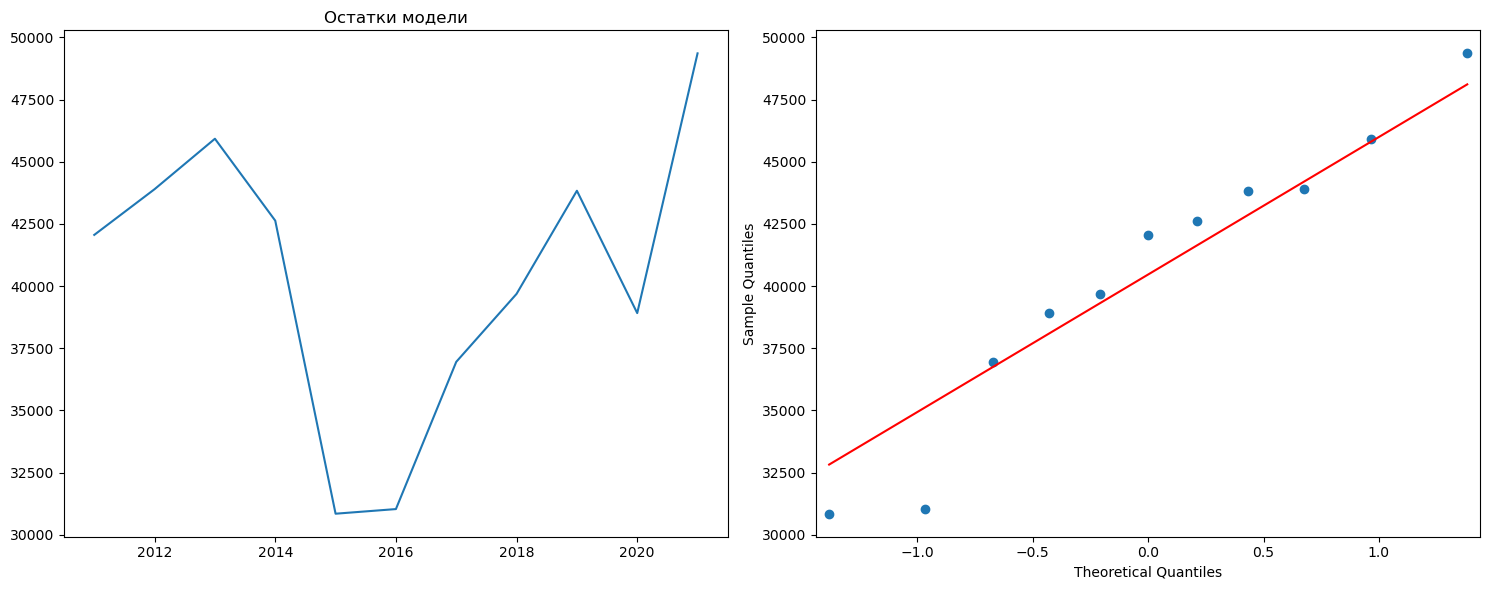

In [74]:
# Визуализация остатков
residuals = results.resid
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].plot(residuals)
ax[0].set_title('Остатки модели')
sm.qqplot(residuals, line='s', ax=ax[1])  # Q-Q график для остатков
plt.tight_layout()

# Проверка на нормальность остатков
from scipy import stats
jb_test = stats.jarque_bera(residuals)
print(f"Значение статистики Jarque-Bera: {jb_test[0]}, p-value: {jb_test[1]}")

#### Проверка адекватности модели. Статистика Дарбина-Утсона

In [75]:
from statsmodels.stats.stattools import durbin_watson

# Вычисляем статистику Дарбина-Уотсона для остатков
dw_statistic = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_statistic}")


Статистика Дарбина-Уотсона: 0.019084247162147957


#### Проверка адекватности модели SARIMAX. Тест Ljung-Box 

In [76]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Проводим Ljung-Box тест
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  11.680743   0.306991


### Датасет: 50-67 Импорт текстиля, текстильных изделий и обуви

In [27]:
# Добавляем константу к независимым переменным для учета свободного члена (intercept) в модели
X_with_const = sm.add_constant(X50_67)
model = SARIMAX(y50_67, exog=X_with_const, order=(0,0,0), seasonal_order=(0,1,0,12))
results = model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                                       SARIMAX Results                                                        
Dep. Variable:     50-67 Импорт текстиля, текстильных изделий и обуви, млн. долл. США   No. Observations:                   11
Model:                                                           SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                                                                Fri, 03 May 2024   AIC                             10.000
Time:                                                                        09:24:00   BIC                                nan
Sample:                                                                             0   HQIC                               nan
                                                                                 - 11                                         
Covariance Type:                                                                  opg                          

In [28]:
# Вычисление метрик MSE и MAE
mse50_67 = mean_squared_error(y50_67[-4:], forecast.predicted_mean)
mae50_67 = mean_absolute_error(y50_67[-4:], forecast.predicted_mean)

print("MSE:", mse50_67)
print("MAE:", mae50_67)

MSE: 43604148.12622093
MAE: 4463.0819


#### Проверка адекватности модели. Статистика Харке-Бера

Значение статистики Jarque-Bera: 0.8555532293467436, p-value: 0.6519570361687599


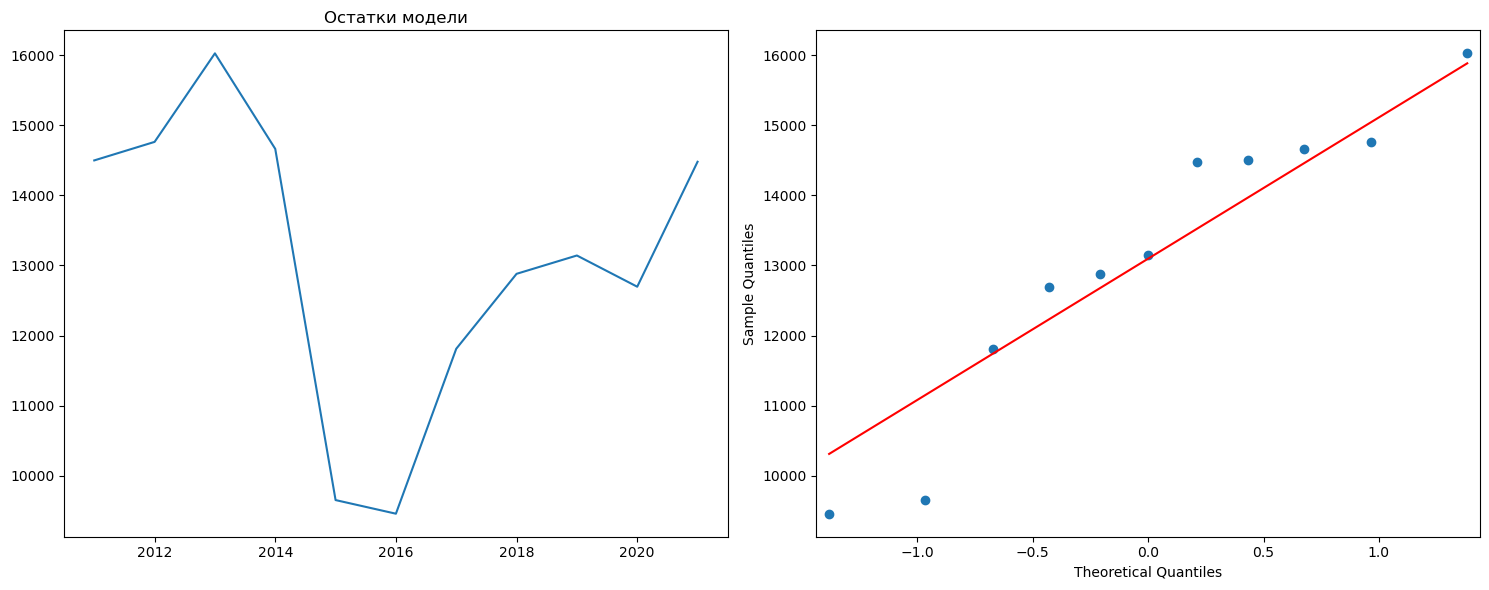

In [78]:
# Визуализация остатков
residuals = results.resid
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].plot(residuals)
ax[0].set_title('Остатки модели')
sm.qqplot(residuals, line='s', ax=ax[1])  # Q-Q график для остатков
plt.tight_layout()

# Проверка на нормальность остатков
from scipy import stats
jb_test = stats.jarque_bera(residuals)
print(f"Значение статистики Jarque-Bera: {jb_test[0]}, p-value: {jb_test[1]}")

#### Проверка адекватности модели. Статистика дарбина-Уотсона

In [79]:
from statsmodels.stats.stattools import durbin_watson

# Вычисляем статистику Дарбина-Уотсона для остатков
dw_statistic = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_statistic}")


Статистика Дарбина-Уотсона: 0.0201000005618744


#### Проверка адекватности модели SARIMAX. Тест Ljung-Box 

In [80]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Проводим Ljung-Box тест
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  11.624438   0.310977


### Датасет: 72-83 Импорт металлов и изделий из них

In [29]:
# Добавляем константу к независимым переменным для учета свободного члена (intercept) в модели
X_with_const = sm.add_constant(X72_83)
model = SARIMAX(y72_83, exog=X_with_const, order=(0,0,0), seasonal_order=(0,1,0,12))
results = model.fit()

# Вывод резюме модели
print(results.summary())

# Прогнозирование (замените steps на желаемое количество периодов для прогнозирования)
forecast = results.get_forecast(steps=4, exog=X_with_const.iloc[-4:])
print("Прогноз:", forecast.predicted_mean)


                                                 SARIMAX Results                                                  
Dep. Variable:     72-83 Импорт металлов и изделий из них, млн. долл. США   No. Observations:                   11
Model:                                               SARIMAX(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                                                    Fri, 03 May 2024   AIC                             10.000
Time:                                                            09:24:45   BIC                                nan
Sample:                                                                 0   HQIC                               nan
                                                                     - 11                                         
Covariance Type:                                                      opg                                         
                                                                    coef    std 

In [30]:
# Вычисление метрик MSE и MAE
mse72_83 = mean_squared_error(y72_83[-4:], forecast.predicted_mean)
mae72_83 = mean_absolute_error(y72_83[-4:], forecast.predicted_mean)

print("MSE:", mse72_83)
print("MAE:", mae72_83)

MSE: 42322434.65041726
MAE: 4499.540925000001


#### Проверка адекватности модели SARIMAX. Тест Харке-Бера

Значение статистики Jarque-Bera: 1.1162852371669993, p-value: 0.5722710028565379


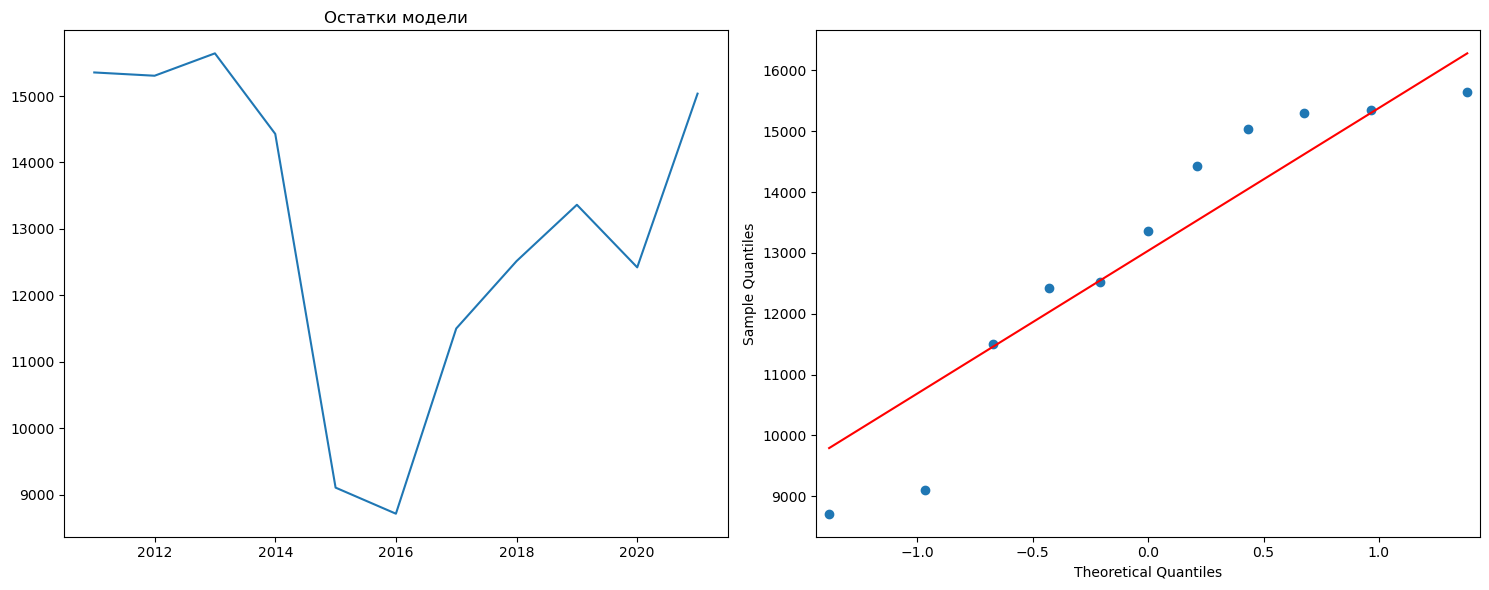

In [82]:
# Визуализация остатков
residuals = results.resid
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].plot(residuals)
ax[0].set_title('Остатки модели')
sm.qqplot(residuals, line='s', ax=ax[1])  # Q-Q график для остатков
plt.tight_layout()

# Проверка на нормальность остатков
from scipy import stats
jb_test = stats.jarque_bera(residuals)
print(f"Значение статистики Jarque-Bera: {jb_test[0]}, p-value: {jb_test[1]}")

#### Проверка адекватности модели SARIMAX. Статистика Дарбина-Уотсона

In [83]:
from statsmodels.stats.stattools import durbin_watson

# Вычисляем статистику Дарбина-Уотсона для остатков
dw_statistic = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_statistic}")


Статистика Дарбина-Уотсона: 0.024527084068694326


#### Проверка адекватности модели SARIMAX. Тест Ljung-Box 

In [84]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Проводим Ljung-Box тест
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
10  14.643428   0.145613
